# PyTorch Basics

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## Download the dataset

Load the `MNIST` dataset from TorchVision.
- This dataset contains 60,000 training images and 10,000 test images of handwritten digits.
- Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total.
- Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker.
- This pixel-value is an integer between 0 and 255, inclusive.

`datasets.MNIST()` accepts the following parameters:
- `root` - the path where the train/test data is stored
- `train` - a boolean value that indicates whether the dataset should be the training dataset or the test dataset
- `download` - a boolean value that indicates whether the dataset should be downloaded if it's not available at `root`
- `transform` - an optional transform function that takes in an PIL image and returns a transformed version.

In [2]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

`torch.utils.data.Dataset` is an abstract class representing a dataset. It stores the samples and their corresponding labels.
`torch.utils.data.DataLoader` wraps an iterable around the `Dataset`.

`DataLoader` supports both map-style and iterable-style datasets with single- or multi-process loading, customizing loading order and optional automatic batching (collation) and memory pinning.

In [3]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


## Create a Model

### `device`

`torch.device` is an object representing the device on which a `torch.Tensor` is or will be allocated.
`torch.device` objects are used as arguments to many methods in the `torch` package.
`torch.device` objects are typically constructed using `torch.device("cuda")` or `torch.device("cpu")`.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


### `nn.Module`

- `nn.Module` is the base class for all neural network modules.
- The layers of the model are defined in the `__init__` function and the forward pass of the model is defined in the `forward` function.
- `nn.Module` keeps track of the layers and parameters of the model.
- The `device` argument is used to move the model to the GPU if available. The default value is `cpu`.

#### Common Layers

- `nn.Conv2d`: Convolutional layer for 2D inputs.
- `nn.CrossEntropyLoss`: Computes the cross-entropy loss between the input and target.
- `nn.Dropout`: Randomly zeroes some of the elements of the input tensor with a given probability during training.
- `nn.Embedding`: Embedding layer that maps discrete inputs to continuous vectors.
- `nn.Flatten`: Flattens a contiguous range of dims into a 1D tensor.
- `nn.Linear`: Linear layer that applies a linear transformation to the input tensor.
- `nn.LSTM`: Long Short-Term Memory recurrent neural network layer.
- `nn.MaxPool2d`: Max pooling layer for 2D inputs.
- `nn.ReLU`: Rectified Linear Unit activation function.
- `nn.Softmax`: Softmax activation function that converts the input tensor to a probability distribution.

> Read more about the supported layers [here](https://pytorch.org/docs/stable/nn.html).


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [6]:
# Create a model instance and move it to the GPU if available
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


## Training the Model

To train a model, we need to define the following:

- **Loss function** - measures how well the output of a model for a given input matches the target output. The goal of training is to minimize this difference.
- **Optimizer** - defines how the model parameters are updated based on the loss function. The simplest optimizer is stochastic gradient descent (SGD).

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print loss every 100 batches
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

## Test the model

We will test the model's accuracy on the test dataset to ensure it is learning.
We will check the accuracy by comparing the model's predictions to the ground-truth labels of the test dataset.

In [9]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    model.eval()
    test_loss, correct = 0, 0

    # Turn off gradients for validation, saves memory and computations (no need to compute gradients for validation)
    with torch.no_grad():

        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            test_loss += loss_fn(pred, y).item() # sum up batch loss
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # sum up correct predictions

    # Calculate average loss and accuracy
    test_loss /= num_batches
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Train, Test, and Save the Model

`epochs` is the number of times the model will iterate over the entire training dataset.
In each iteration, the model learns the parameters to better map inputs to outputs.
It is common to see the loss decrease and the accuracy increase with each epoch.

> **Note**: Training can take a few minutes, depending on your hardware.

In [10]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304379  [    0/60000]
loss: 2.303697  [ 6400/60000]
loss: 2.294250  [12800/60000]
loss: 2.294914  [19200/60000]
loss: 2.299555  [25600/60000]
loss: 2.298127  [32000/60000]
loss: 2.284647  [38400/60000]
loss: 2.284154  [44800/60000]
loss: 2.282887  [51200/60000]
loss: 2.275116  [57600/60000]
Test Error: 
 Accuracy: 29.2%, Avg loss: 2.281900 

Epoch 2
-------------------------------
loss: 2.283860  [    0/60000]
loss: 2.283749  [ 6400/60000]
loss: 2.275879  [12800/60000]
loss: 2.268411  [19200/60000]
loss: 2.283331  [25600/60000]
loss: 2.283383  [32000/60000]
loss: 2.258339  [38400/60000]
loss: 2.261001  [44800/60000]
loss: 2.256265  [51200/60000]
loss: 2.245658  [57600/60000]
Test Error: 
 Accuracy: 32.0%, Avg loss: 2.255985 

Epoch 3
-------------------------------
loss: 2.259030  [    0/60000]
loss: 2.258939  [ 6400/60000]
loss: 2.251599  [12800/60000]
loss: 2.232405  [19200/60000]
loss: 2.260883  [25600/60000]
loss: 2.263092  [32000/600

### Save the model

The model's state dictionary contains the learned parameters.

`torch.save` is used to save the model's state dictionary to a file.
`.pth` is the common file extension for PyTorch models.

In [11]:
torch.save(model.state_dict(), "basic-mnist.pth")
print("Saved PyTorch Model State to basic-mnist.pth")

Saved PyTorch Model State to basic-mnist.pth


### Load the model

`torch.load` is used to load the model's state dictionary from a file.

In [12]:
model = NeuralNetwork()
model.load_state_dict(torch.load("basic-mnist.pth"))
print("Loaded PyTorch Model State from basic-mnist.pth")

Loaded PyTorch Model State from basic-mnist.pth


### Evaluate the model

In [13]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

model.eval()
x, y = test_data[0][0], test_data[0][1]

with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "7", Actual: "7"


#### Test with a random image from the test dataset.

Predicted: "6", Actual: "5"


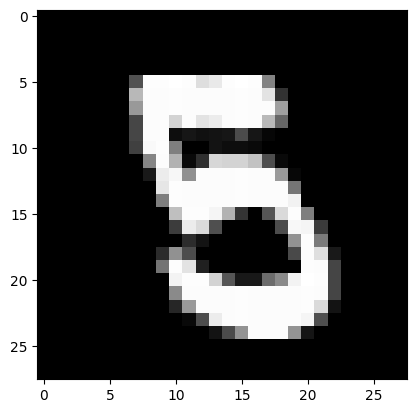

In [16]:
import random
import matplotlib.pyplot as plt

model.eval()
rand_index = random.randint(0, len(test_data))
x, y = test_data[rand_index][0], test_data[rand_index][1]

with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

    plt.imshow(x.view(28, 28), cmap='gray')
    plt.show()